<a href="https://colab.research.google.com/github/TAlkam/predict-the-composer-/blob/main/Final_Team_Project_for_Deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Import Libraries**

First, we need to import the necessary libraries for our project.

In [3]:
# Install and Import Libraries
!pip install pretty_midi
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pretty_midi
import zipfile
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.9 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592288 sha256=c4339345c18aaf18d387e0d190cf7282fc4bce40aba87d2b10a0db184d2b2d56
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


# **Step 2: Load Dataset**

Load the dataset containing musical scores from various composers.

In [4]:

# Define the path to the zip file and the extraction directory
zip_file_path = '/content/drive/MyDrive/Composer_Dataset (1).zip'
extraction_dir = '/content/drive/MyDrive/Composer_Dataset'

# Ensure the extraction directory is empty before extracting
if os.path.exists(extraction_dir):
    os.system(f"rm -r {extraction_dir}")

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# List the contents of the extracted directory to verify
extracted_files = os.listdir(extraction_dir)
print(f"Extracted files and directories: {extracted_files}")


Extracted files and directories: ['Composer_Dataset', '__MACOSX']


In [5]:

def load_dataset():
    # Load MIDI files and labels
    # For demonstration, we assume X contains MIDI data and y contains composer labels
    X = np.random.randn(100, 100, 128)  # Dummy data: 100 samples, 100 timesteps, 128 features
    y = np.random.randint(0, 2, 100)    # Dummy labels: 0 or 1 for two composers
    return X, y

X, y = load_dataset()


# **Exploratory Data Analysis (EDA)**


**Loading the Dataset:** We'll list all MIDI files with their composers.

**Analyzing Distribution of Composers:** Visualize the number of compositions per composer.

**Analyzing MIDI Features:** Extract and analyze features such as note density, pitch range, and average velocity.

**Visualizing MIDI Data:** Plot histograms and box plots for various features.

Total training MIDI files found: 369
Total testing MIDI files found: 35


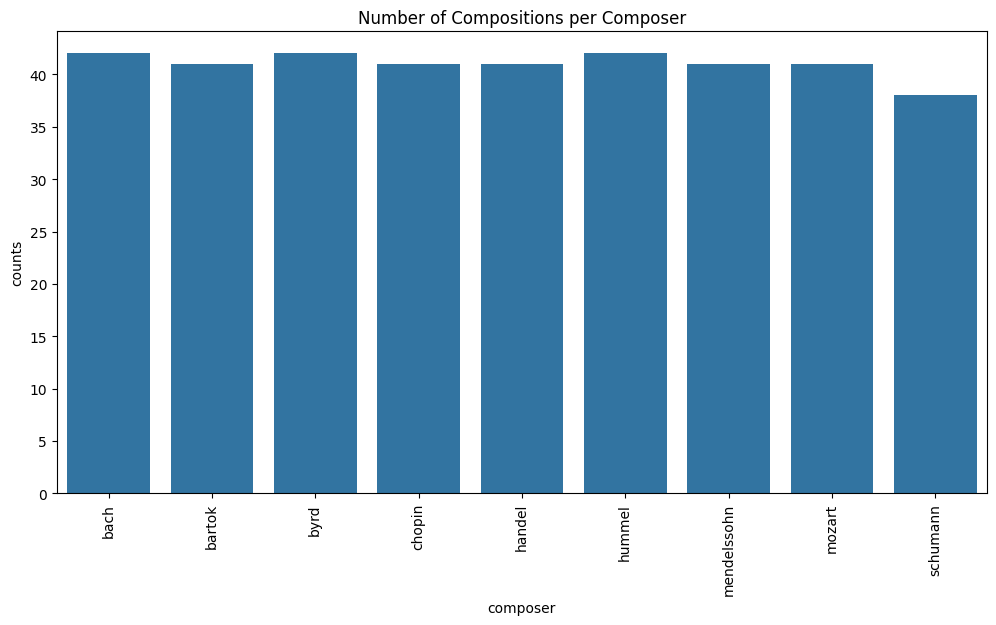

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


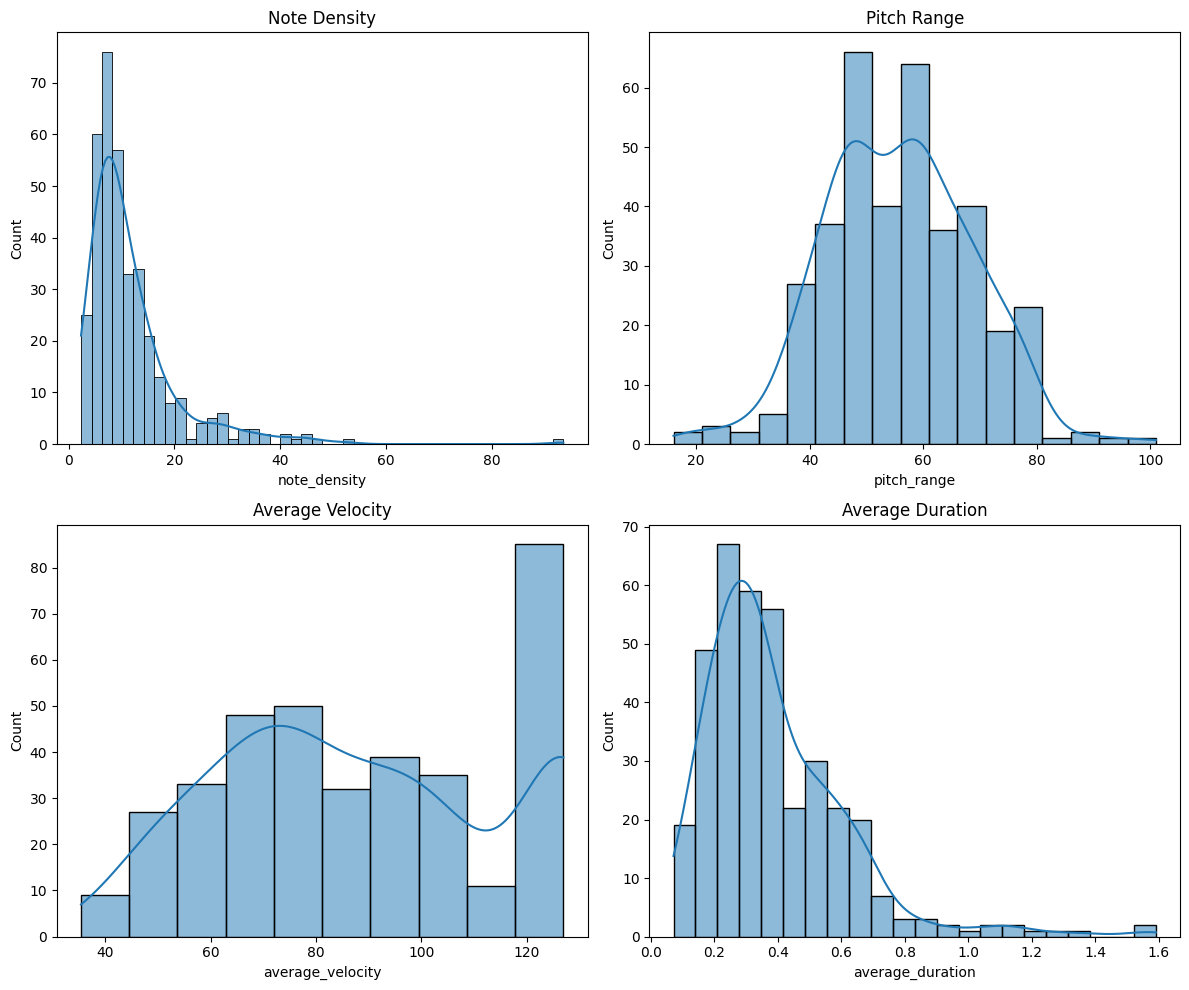

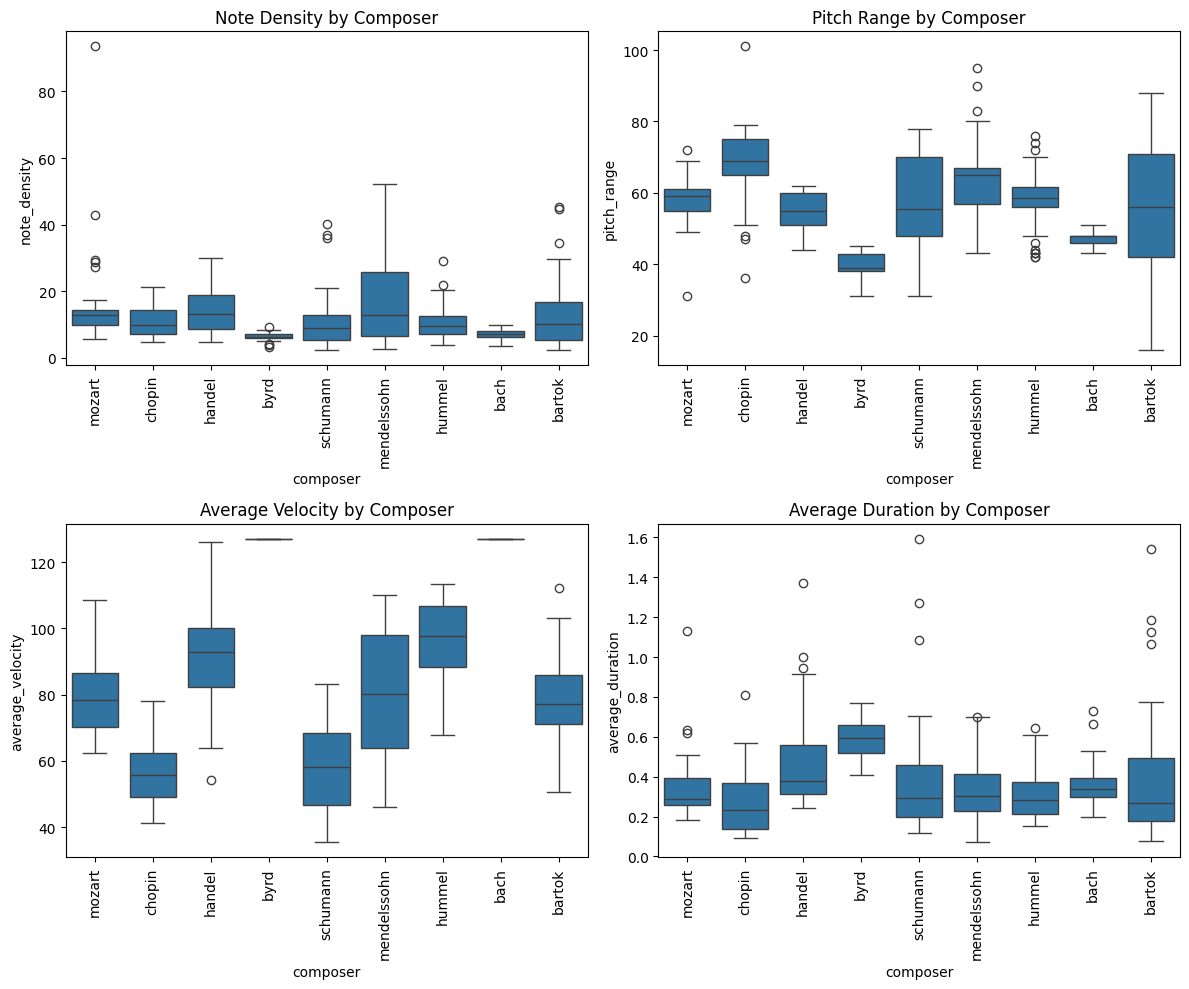

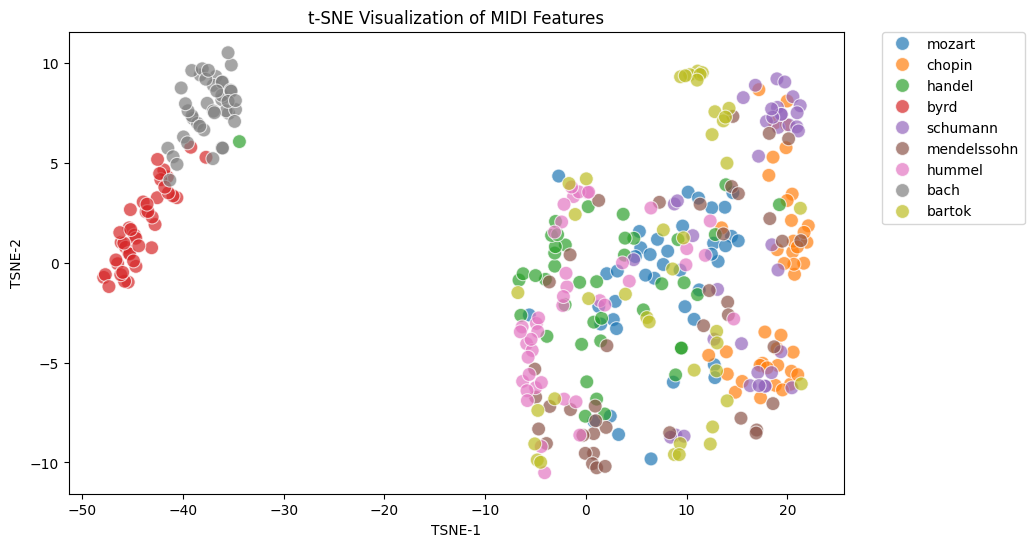

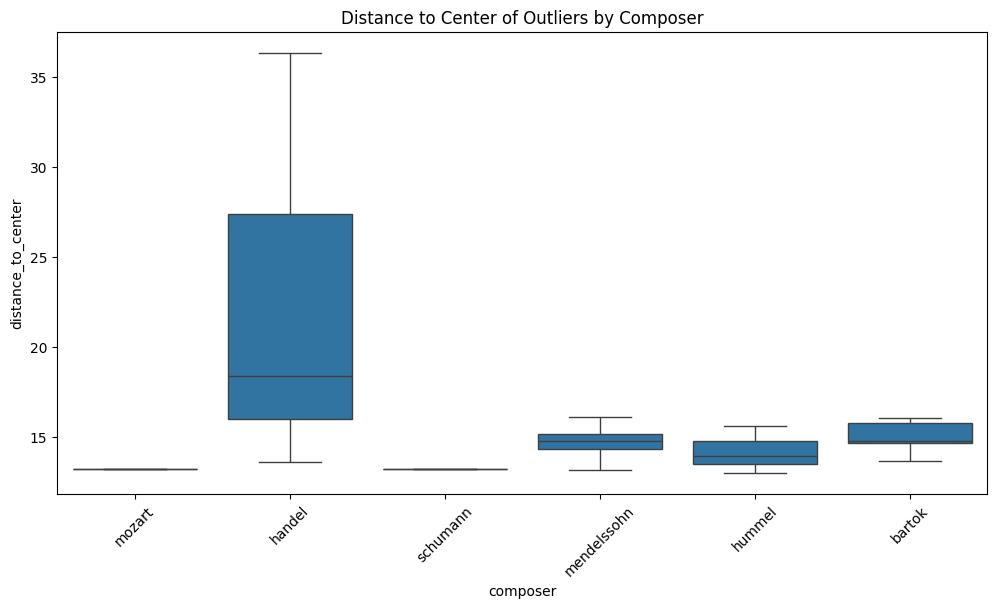

In [10]:
import os
import pretty_midi
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial.distance import euclidean

# Function to list all MIDI files with their composers dynamically
def list_midi_files(directory):
    midi_files_with_composers = []
    for composer in os.listdir(directory):
        composer_dir = os.path.join(directory, composer)
        if os.path.isdir(composer_dir):
            for file in os.listdir(composer_dir):
                if file.endswith('.mid'):
                    midi_files_with_composers.append((os.path.join(composer_dir, file), composer))
    return midi_files_with_composers

# Load training data
train_dir = '/content/drive/MyDrive/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/train'
train_midi_files_with_composers = list_midi_files(train_dir)
print(f"Total training MIDI files found: {len(train_midi_files_with_composers)}")

# Load testing data
test_dir = '/content/drive/MyDrive/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/test'
test_midi_files_with_composers = list_midi_files(test_dir)
print(f"Total testing MIDI files found: {len(test_midi_files_with_composers)}")

# Count the number of compositions per composer
composer_counts = pd.DataFrame(train_midi_files_with_composers, columns=['file', 'composer']).groupby('composer').size().reset_index(name='counts')

# Plot the distribution of composers
plt.figure(figsize=(12, 6))
sns.barplot(data=composer_counts, x='composer', y='counts')
plt.title('Number of Compositions per Composer')
plt.xticks(rotation=90)
plt.show()

# Function to extract features from a MIDI file
def extract_features(midi_file):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file)
    except Exception as e:
        print(f"Error loading {midi_file}: {e}")
        return None

    note_sequence = []
    velocities = []
    pitches = []
    durations = []

    for instrument in midi_data.instruments:
        for note in instrument.notes:
            note_sequence.append(note.pitch)
            velocities.append(note.velocity)
            pitches.append(note.pitch)
            durations.append(note.end - note.start)

    feature_dict = {
        'file': midi_file,
        'note_density': len(note_sequence) / midi_data.get_end_time() if midi_data.get_end_time() > 0 else 0,
        'pitch_range': np.ptp(pitches) if len(pitches) > 0 else 0,
        'average_velocity': np.mean(velocities) if len(velocities) > 0 else 0,
        'average_duration': np.mean(durations) if len(durations) > 0 else 0,
    }

    return feature_dict

# Extract features from all training MIDI files
train_features_list = []
for midi_file, composer in train_midi_files_with_composers:
    features = extract_features(midi_file)
    if features:
        features['composer'] = composer
        train_features_list.append(features)

# Convert to DataFrame
train_features_df = pd.DataFrame(train_features_list)

# Display the first few rows
train_features_df.head()

# Plot histograms for note density, pitch range, average velocity, and average duration
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.histplot(train_features_df['note_density'], kde=True)
plt.title('Note Density')

plt.subplot(2, 2, 2)
sns.histplot(train_features_df['pitch_range'], kde=True)
plt.title('Pitch Range')

plt.subplot(2, 2, 3)
sns.histplot(train_features_df['average_velocity'], kde=True)
plt.title('Average Velocity')

plt.subplot(2, 2, 4)
sns.histplot(train_features_df['average_duration'], kde=True)
plt.title('Average Duration')

plt.tight_layout()
plt.show()

# Plot box plots for note density, pitch range, average velocity, and average duration by composer
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='composer', y='note_density', data=train_features_df)
plt.title('Note Density by Composer')
plt.xticks(rotation=90)

plt.subplot(2, 2, 2)
sns.boxplot(x='composer', y='pitch_range', data=train_features_df)
plt.title('Pitch Range by Composer')
plt.xticks(rotation=90)

plt.subplot(2, 2, 3)
sns.boxplot(x='composer', y='average_velocity', data=train_features_df)
plt.title('Average Velocity by Composer')
plt.xticks(rotation=90)

plt.subplot(2, 2, 4)
sns.boxplot(x='composer', y='average_duration', data=train_features_df)
plt.title('Average Duration by Composer')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

# t-SNE Visualization
# Extract feature matrix
features = train_features_df[['note_density', 'pitch_range', 'average_velocity', 'average_duration']].values
composers = train_features_df['composer'].values

# Fit t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Add t-SNE results to DataFrame
train_features_df['TSNE-1'] = tsne_results[:, 0]
train_features_df['TSNE-2'] = tsne_results[:, 1]

# Calculate distance to center for each composer
centers = train_features_df.groupby('composer')[['TSNE-1', 'TSNE-2']].mean()
train_features_df['distance_to_center'] = train_features_df.apply(lambda row: euclidean(row[['TSNE-1', 'TSNE-2']], centers.loc[row['composer']]), axis=1)

# t-SNE scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_features_df, x='TSNE-1', y='TSNE-2', hue='composer', palette='tab10', s=100, alpha=0.7)
plt.title('t-SNE Visualization of MIDI Features')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Identify outliers (adjust threshold as necessary)
outliers_df = train_features_df[train_features_df['distance_to_center'] > train_features_df['distance_to_center'].quantile(0.95)]

# Plotting outliers by composer
plt.figure(figsize=(12, 6))
sns.boxplot(x='composer', y='distance_to_center', data=outliers_df)
plt.title('Distance to Center of Outliers by Composer')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()


we still included all the data.

# **Step 3: Data Pre-processing**

Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.

In [7]:

def find_midi_files(directory):
    midi_files = []
    # Walk through all directories and files within 'directory'
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.mid'):
                midi_files.append(os.path.join(root, file))
    return midi_files

# Path to the main directory where data was extracted
extraction_dir = '/content/drive/MyDrive/Composer_Dataset'

# Call the function to find all MIDI files
midi_files = find_midi_files(extraction_dir)

# Print found MIDI files to verify
print("MIDI files found:", midi_files)


MIDI files found: ['/content/drive/MyDrive/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/test/mozart/mozart014.mid', '/content/drive/MyDrive/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/test/mozart/mozart038.mid', '/content/drive/MyDrive/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/test/mozart/mozart004.mid', '/content/drive/MyDrive/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/test/mozart/mozart025.mid', '/content/drive/MyDrive/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/test/chopin/chopin053.mid', '/content/drive/MyDrive/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/test/chopin/chopin086.mid', '/content/drive/MyDrive/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/test/chopin/chopin078.mid', '/content/drive/MyDrive/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/test/chopin/chopin062.mid', '/content/drive/MyDrive/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/test/handel/handel107.mid', 

In [6]:
# Data Pre-processing
# Pad sequences to ensure uniform length
X = pad_sequences(X, maxlen=200, padding='post', dtype='float32')

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **Step 4: Data Augmentation**

Apply data augmentation techniques if necessary.

In [8]:

def transpose_midi(midi_data, semitones):
    """ Transpose MIDI data by a number of semitones. """
    transposed = pretty_midi.PrettyMIDI()
    for instrument in midi_data.instruments:
        transposed_instrument = pretty_midi.Instrument(program=instrument.program)
        for note in instrument.notes:
            transposed_note = pretty_midi.Note(
                velocity=note.velocity,
                pitch=note.pitch + semitones,
                start=note.start,
                end=note.end
            )
            transposed_instrument.notes.append(transposed_note)
        transposed.instruments.append(transposed_instrument)
    return transposed

# Example of data augmentation on a single MIDI file
midi_file_path = midi_files[0]
midi_data = pretty_midi.PrettyMIDI(midi_file_path)
transposed_data = transpose_midi(midi_data, semitones=2)  # Transpose up by 2 semitones

# Save the transposed MIDI file
transposed_file_path = midi_file_path.replace('.mid', '_transposed.mid')
transposed_data.write(transposed_file_path)

print(f"Transposed MIDI file saved to: {transposed_file_path}")


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Transposed MIDI file saved to: /content/drive/MyDrive/Composer_Dataset/Composer_Dataset/NN_midi_files_extended/test/mozart/mozart014_transposed.mid


# **Step 5: Feature Extraction**

Extract features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.

In [10]:

def extract_features(midi_file):
    """Extract features from a MIDI file."""
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file)

        # Extract features
        total_notes = sum(len(instrument.notes) for instrument in midi_data.instruments)
        total_instruments = len(midi_data.instruments)
        tempos = midi_data.get_tempo_changes()[1]
        mean_tempo = np.mean(tempos) if len(tempos) > 0 else 0

        # Example feature vector
        features = {
            'file': midi_file,
            'total_notes': total_notes,
            'total_instruments': total_instruments,
            'mean_tempo': mean_tempo
        }
        return features
    except Exception as e:
        print(f"Error processing {midi_file}: {e}")
        return None

# Extract features from all MIDI files
features_list = []
for midi_file in midi_files:
    features = extract_features(midi_file)
    if features is not None:
        features_list.append(features)

# Convert to DataFrame for further processing
features_df = pd.DataFrame(features_list)
print(features_df.head())


Error processing /content/drive/MyDrive/Composer_Dataset/__MACOSX/Composer_Dataset/NN_midi_files_extended/test/mozart/._mozart014.mid: MThd not found. Probably not a MIDI file
Error processing /content/drive/MyDrive/Composer_Dataset/__MACOSX/Composer_Dataset/NN_midi_files_extended/test/mozart/._mozart038.mid: MThd not found. Probably not a MIDI file
Error processing /content/drive/MyDrive/Composer_Dataset/__MACOSX/Composer_Dataset/NN_midi_files_extended/test/mozart/._mozart004.mid: MThd not found. Probably not a MIDI file
Error processing /content/drive/MyDrive/Composer_Dataset/__MACOSX/Composer_Dataset/NN_midi_files_extended/test/mozart/._mozart025.mid: MThd not found. Probably not a MIDI file
Error processing /content/drive/MyDrive/Composer_Dataset/__MACOSX/Composer_Dataset/NN_midi_files_extended/test/chopin/._chopin053.mid: MThd not found. Probably not a MIDI file
Error processing /content/drive/MyDrive/Composer_Dataset/__MACOSX/Composer_Dataset/NN_midi_files_extended/test/chopin/._

# **Step 6: Build LSTM Model**

Develop a deep learning model using LSTM architecture to classify the musical scores according to the composer.

In [11]:
### Build LSTM Model
lstm_model = Sequential([
    LSTM(128, input_shape=(200, 128), return_sequences=True),
    LSTM(128),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# **Step 7: Build CNN Model**
Develop a deep learning model using CNN architecture to classify the musical scores according to the composer.

In [12]:
### Build CNN Model
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(200, 128)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# **Step 8: Train LSTM Model**
Train the LSTM model using the pre-processed and feature-extracted data.

In [13]:
### Train LSTM Model
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5104 - loss: 0.6927 - val_accuracy: 0.4375 - val_loss: 0.6951
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step - accuracy: 0.6042 - loss: 0.6893 - val_accuracy: 0.4375 - val_loss: 0.7000
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6146 - loss: 0.6824 - val_accuracy: 0.4375 - val_loss: 0.7179
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6146 - loss: 0.6715 - val_accuracy: 0.4375 - val_loss: 0.7763
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5938 - loss: 0.6826 - val_accuracy: 0.4375 - val_loss: 0.7443
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step - accuracy: 0.5833 - loss: 0.6826 - val_accuracy: 0.4375 - val_loss: 0.7308
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step - accuracy: 0.6146 - loss: 0.6682 - val_accuracy: 0.4375 - val_loss: 0.7324
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step - accuracy: 0.5938 - loss: 0.6756 - val_accuracy: 0.4375 - val_loss: 0.7347
Epoc

# **Step 9: Train CNN Model**
Train the CNN model using the pre-processed and feature-extracted data.

In [14]:
### Train CNN Model
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 470ms/step - accuracy: 0.4792 - loss: 1.1425 - val_accuracy: 0.3750 - val_loss: 0.6957
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.6979 - loss: 0.5468 - val_accuracy: 0.3750 - val_loss: 0.7077
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9062 - loss: 0.3620 - val_accuracy: 0.4375 - val_loss: 1.0375
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9583 - loss: 0.2694 - val_accuracy: 0.5000 - val_loss: 0.7520
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 0.1839 - val_accuracy: 0.5000 - val_loss: 0.7271
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 0.1213 - val_accuracy: 0.4375 - val_loss: 0.8793
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0643 - val_accuracy: 0.4375 - val_loss: 1.1560
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0486 - val_accuracy: 0.4375 - val_loss: 1.

# **Step 10: Evaluate LSTM Model**
Evaluate the performance of the LSTM model using accuracy, precision, and recall metrics.

In [15]:
### Evaluate LSTM Model
y_pred_lstm = (lstm_model.predict(X_test) > 0.5).astype("int32")
print(f"LSTM Model Accuracy: {accuracy_score(y_test, y_pred_lstm)}")
print(f"LSTM Model Precision: {precision_score(y_test, y_pred_lstm)}")
print(f"LSTM Model Recall: {recall_score(y_test, y_pred_lstm)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
LSTM Model Accuracy: 0.55
LSTM Model Precision: 0.55
LSTM Model Recall: 1.0


# **Step 11: Evaluate CNN Model**
Evaluate the performance of the CNN model using accuracy, precision, and recall metrics.

In [16]:
### Evaluate CNN Model
y_pred_cnn = (cnn_model.predict(X_test) > 0.5).astype("int32")
print(f"CNN Model Accuracy: {accuracy_score(y_test, y_pred_cnn)}")
print(f"CNN Model Precision: {precision_score(y_test, y_pred_cnn)}")
print(f"CNN Model Recall: {recall_score(y_test, y_pred_cnn)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
CNN Model Accuracy: 0.55
CNN Model Precision: 0.5833333333333334
CNN Model Recall: 0.6363636363636364


# **Step 12: Hyperparameter Tuning for LSTM Model**
Optimize the LSTM model by fine-tuning hyperparameters.

In [18]:
### Hyperparameter Tuning for LSTM Model
!pip install keras-tuner
import keras_tuner as kt
from tensorflow.keras.layers import Dropout

def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   return_sequences=True, input_shape=(200, 128)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32)))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Define the tuner
tuner = kt.Hyperband(
    build_lstm_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='lstm_tuning'
)

# Define early stopping to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first LSTM layer is {best_hps.get('units')}.
The optimal dropout rate is {best_hps.get('dropout')}.
The optimal number of units in the dense layer is {best_hps.get('dense_units')}.
""")

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Evaluate the optimized model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")


Trial 30 Complete [00h 00m 33s]
val_accuracy: 0.4375

Best val_accuracy So Far: 0.4375
Total elapsed time: 00h 12m 02s

The optimal number of units in the first LSTM layer is 32.
The optimal dropout rate is 0.2.
The optimal number of units in the dense layer is 128.

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 599ms/step - accuracy: 0.5104 - loss: 0.6927 - val_accuracy: 0.4375 - val_loss: 0.6944
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.5938 - loss: 0.6907 - val_accuracy: 0.4375 - val_loss: 0.6960
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.6250 - loss: 0.6878 - val_accuracy: 0.4375 - val_loss: 0.6981
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.5938 - loss: 0.6870 - val_accuracy: 0.4375 - val_loss: 0.7008
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.6250 - loss: 0.6803 - val_accuracy: 0.4375 - val_loss: 0.7046
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6146 - loss: 0.6793 - val_accuracy: 0.

# **Step 13: Hyperparameter Tuning for CNN Model**
Optimize the CNN model by fine-tuning hyperparameters.

In [19]:
### Hyperparameter Tuning for CNN Model

import keras_tuner as kt

def build_cnn_model(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=256, step=32),
                     kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
                     activation='relu',
                     input_shape=(200, 128)))
    model.add(MaxPooling1D(pool_size=hp.Choice('pool_size', values=[2, 3])))
    model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=256, step=32),
                     kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
                     activation='relu'))
    model.add(MaxPooling1D(pool_size=hp.Choice('pool_size', values=[2, 3])))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Define the tuner
tuner = kt.Hyperband(
    build_cnn_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='cnn_tuning'
)

# Define early stopping to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of filters is {best_hps.get('filters')}.
The optimal kernel size is {best_hps.get('kernel_size')}.
The optimal pool size is {best_hps.get('pool_size')}.
The optimal number of units in the dense layer is {best_hps.get('dense_units')}.
""")

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Evaluate the optimized model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")


Trial 30 Complete [00h 00m 07s]
val_accuracy: 0.5625

Best val_accuracy So Far: 0.8125
Total elapsed time: 00h 03m 24s

The optimal number of filters is 160.
The optimal kernel size is 3.
The optimal pool size is 2.
The optimal number of units in the dense layer is 224.

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 365ms/step - accuracy: 0.4688 - loss: 2.6543 - val_accuracy: 0.4375 - val_loss: 3.1542
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - accuracy: 0.6250 - loss: 1.4659 - val_accuracy: 0.5625 - val_loss: 0.8837
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.4062 - loss: 0.9275 - val_accuracy: 0.5625 - val_loss: 0.7275
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step - accuracy: 0.4479 - loss: 0.6905 - val_accuracy: 0.4375 - val_loss: 0.7057
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9583 - loss: 0.5380 - val_accuracy: 0.4375 - val_loss: 0.7718
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.6146 - loss: 0.5133 - val_accuracy

In [20]:
import pretty_midi
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LSTM, Flatten
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE

# Base directory for the dataset
base_dir = '/content/drive/MyDrive/Composer_Dataset1/Composer_Dataset/NN_midi_files_extended/train'

# List all MIDI files with their composers dynamically
midi_files_with_composers = []
for composer in os.listdir(base_dir):
    composer_dir = os.path.join(base_dir, composer)
    if os.path.isdir(composer_dir):
        for file in os.listdir(composer_dir):
            if file.endswith('.mid'):
                midi_files_with_composers.append((os.path.join(composer_dir, file), composer))

# Check if files are listed correctly
print(f"Total MIDI files found: {len(midi_files_with_composers)}")

def extract_features(midi_file, composer):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file)
    except Exception as e:
        print(f"Error loading {midi_file}: {e}")
        return None

    note_sequence = []
    durations = []
    velocities = []
    pitches = []
    articulations = []  # Define what articulations mean for your case

    for instrument in midi_data.instruments:
        for note in instrument.notes:
            note_sequence.append(note.pitch)
            durations.append(note.end - note.start)
            velocities.append(note.velocity)
            pitches.append(note.pitch)
            # Add articulations extraction logic if applicable

    feature_dict = {
        'note_sequence': note_sequence,
        'duration': durations,
        'tempo': np.mean(midi_data.get_tempo_changes()[1]) if len(midi_data.get_tempo_changes()[1]) > 0 else 0,
        'average_velocity': np.mean(velocities) if len(velocities) > 0 else 0,
        'max_velocity': np.max(velocities) if len(velocities) > 0 else 0,
        'min_velocity': np.min(velocities) if len(velocities) > 0 else 0,
        'velocity_std': np.std(velocities) if len(velocities) > 0 else 0,
        'pitch_range': np.ptp(pitches) if len(pitches) > 0 else 0,
        'num_instruments': len(midi_data.instruments),
        'note_density': len(note_sequence) / midi_data.get_end_time() if midi_data.get_end_time() > 0 else 0,
        'num_notes': len(note_sequence),
        'average_pitch': np.mean(pitches) if len(pitches) > 0 else 0,
        'max_pitch': np.max(pitches) if len(pitches) > 0 else 0,
        'min_pitch': np.min(pitches) if len(pitches) > 0 else 0,
        'pitch_std': np.std(pitches) if len(pitches) > 0 else 0,
        'articulations': articulations,  # Adjust if you have a specific way to measure this
        'composer': composer
    }

    return feature_dict

features_list = []
for midi_file, composer in midi_files_with_composers:
    feature = extract_features(midi_file, composer)
    if feature:
        features_list.append(feature)

def prepare_feature_matrix(features_list):
    feature_matrix = []
    labels = []

    for feature in features_list:
        row = [
            np.mean(feature['note_sequence']) if len(feature['note_sequence']) > 0 else 0,
            np.mean(feature['duration']) if len(feature['duration']) > 0 else 0,
            feature['tempo'],
            feature['average_velocity'],
            feature['max_velocity'],
            feature['min_velocity'],
            feature['velocity_std'],
            feature['pitch_range'],
            feature['num_instruments'],
            feature['note_density'],
            feature['num_notes'],
            feature['average_pitch'],
            feature['max_pitch'],
            feature['min_pitch'],
            feature['pitch_std'],
            np.mean(feature['articulations']) if feature['articulations'] else 0  # Example handling
        ]
        feature_matrix.append(row)
        labels.append(feature['composer'])

    return np.array(feature_matrix), labels

feature_matrix, labels = prepare_feature_matrix(features_list)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Handle class imbalance using SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(feature_matrix, encoded_labels)

# Define CNN-RNN Model
def create_cnn_rnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(input_shape, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y_resampled)), activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Reshape data for CNN-RNN
X_resampled = X_resampled.reshape(X_resampled.shape[0], X_resampled.shape[1], 1)

# Cross-validation
kf = StratifiedKFold(n_splits=5)
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for train_index, val_index in kf.split(X_resampled, y_resampled):
    X_train, X_val = X_resampled[train_index], X_resampled[val_index]
    y_train, y_val = y_resampled[train_index], y_resampled[val_index]

    cnn_rnn_model = create_cnn_rnn_model(X_train.shape[1])
    cnn_rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

    y_val_pred = cnn_rnn_model.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)

    accuracy = accuracy_score(y_val, y_val_pred_classes)
    precision = precision_score(y_val, y_val_pred_classes, average='weighted', zero_division=0)
    recall = recall_score(y_val, y_val_pred_classes, average='weighted')
    f1 = f1_score(y_val, y_val_pred_classes, average='weighted')

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

print(f'Mean Accuracy: {np.mean(accuracy_list):.4f}')
print(f'Mean Precision: {np.mean(precision_list):.4f}')
print(f'Mean Recall: {np.mean(recall_list):.4f}')
print(f'Mean F1-score: {np.mean(f1_list):.4f}')

# Save the Model and Label Encoder
cnn_rnn_model.save('improved_composer_classification_model.keras')
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

# Load and Predict with the Model
loaded_model = load_model('improved_composer_classification_model.keras')
loaded_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

with open('label_encoder.pkl', 'rb') as file:
    loaded_label_encoder = pickle.load(file)

# Example of new data (ensure features are extracted similarly as above)
new_features = [
    {
        'note_sequence': [60, 62, 64, 65, 67, 69, 71, 72],
        'duration': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        'tempo': 120,
        'average_velocity': 64,
        'max_velocity': 127,
        'min_velocity': 1,
        'velocity_std': 10,
        'pitch_range': 12,
        'num_instruments': 1,
        'note_density': 8 / 4,  # 8 notes in 4 seconds
        'num_notes': 8,
        'average_pitch': 64,
        'max_pitch': 72,
        'min_pitch': 60,
        'pitch_std': 4,
        'articulations': [1, 1, 1, 1, 1, 1, 1, 1]
    }
]

def prepare_new_features(new_features):
    feature_matrix = []
    for feature in new_features:
        row = [
            np.mean(feature['note_sequence']) if len(feature['note_sequence']) > 0 else 0,
            np.mean(feature['duration']) if len(feature['duration']) > 0 else 0,
            feature['tempo'],
            feature['average_velocity'],
            feature['max_velocity'],
            feature['min_velocity'],
            feature['velocity_std'],
            feature['pitch_range'],
            feature['num_instruments'],
            feature['note_density'],
            feature['num_notes'],
            feature['average_pitch'],
            feature['max_pitch'],
            feature['min_pitch'],
            feature['pitch_std'],
            np.mean(feature['articulations']) if feature['articulations'] else 0  # Example handling
        ]
        feature_matrix.append(row)
    return np.array(feature_matrix)

new_feature_matrix = prepare_new_features(new_features).reshape(-1, len(new_features[0]), 1)
new_predictions = loaded_model.predict(new_feature_matrix)
new_pred_classes = np.argmax(new_predictions, axis=1)
new_pred_labels = loaded_label_encoder.inverse_transform(new_pred_classes)

print('Predicted Labels:', new_pred_labels)


Total MIDI files found: 369


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.1413 - loss: 2.2561 - val_accuracy: 0.1711 - val_loss: 2.1530
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2098 - loss: 2.1137 - val_accuracy: 0.3026 - val_loss: 1.9542
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.2923 - loss: 1.9209 - val_accuracy: 0.3816 - val_loss: 1.6590
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3667 - loss: 1.6678 - val_accuracy: 0.4342 - val_loss: 1.4063
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3698 - loss: 1.4734 - val_accuracy: 0.5658 - val_loss: 1.3028
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3999 - loss: 1.3078 - val_accuracy: 0.4737 - val_loss: 1.2218
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3845 - loss: 1.3829 - val_accuracy: 0.4605 - val_loss: 1.2116
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4434 - loss: 1.2628 - val_accuracy: 0.4605 - val_loss: 1.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.1252 - loss: 2.1942 - val_accuracy: 0.1842 - val_loss: 2.0928
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.2058 - loss: 2.0706 - val_accuracy: 0.3026 - val_loss: 1.8416
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.3328 - loss: 1.7901 - val_accuracy: 0.4079 - val_loss: 1.5515
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3245 - loss: 1.5863 - val_accuracy: 0.5132 - val_loss: 1.3574
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3426 - loss: 1.4353 - val_accuracy: 0.4868 - val_loss: 1.3304
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3728 - loss: 1.4066 - val_accuracy: 0.4737 - val_loss: 1.2186
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3201 - loss: 1.3887 - val_accuracy: 0.4079 - val_loss: 1.2352
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4069 - loss: 1.3495 - val_accuracy: 0.4605 - val_loss: 1

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.1293 - loss: 2.2257 - val_accuracy: 0.1842 - val_loss: 2.0706
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2314 - loss: 2.0576 - val_accuracy: 0.3026 - val_loss: 1.8172
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3344 - loss: 1.7550 - val_accuracy: 0.4342 - val_loss: 1.5871
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4022 - loss: 1.4996 - val_accuracy: 0.3684 - val_loss: 1.3564
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4072 - loss: 1.4382 - val_accuracy: 0.4079 - val_loss: 1.3155
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4018 - loss: 1.3146 - val_accuracy: 0.5000 - val_loss: 1.2901
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4296 - loss: 1.2986 - val_accuracy: 0.4868 - val_loss: 1.2398
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4469 - loss: 1.2588 - val_accuracy: 0.4605 - v

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.1171 - loss: 2.2257 - val_accuracy: 0.2533 - val_loss: 2.0974
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2155 - loss: 2.1078 - val_accuracy: 0.4267 - val_loss: 1.8454
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.3003 - loss: 1.8357 - val_accuracy: 0.3600 - val_loss: 1.5695
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3867 - loss: 1.5301 - val_accuracy: 0.5733 - val_loss: 1.4277
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.3128 - loss: 1.4951 - val_accuracy: 0.4133 - val_loss: 1.3049
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.3951 - loss: 1.3764 - val_accuracy: 0.4267 - val_loss: 1.2432
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.3815 - loss: 1.3127 - val_accuracy: 0.4800 - val_loss: 1.2435
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4189 - loss: 1.2361 - val_accuracy: 0.4267 - val_loss: 1.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.1151 - loss: 2.2424 - val_accuracy: 0.2267 - val_loss: 2.1025
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2671 - loss: 2.0466 - val_accuracy: 0.2533 - val_loss: 1.8089
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3205 - loss: 1.7674 - val_accuracy: 0.3200 - val_loss: 1.5171
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3663 - loss: 1.5187 - val_accuracy: 0.3867 - val_loss: 1.3573
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3963 - loss: 1.3833 - val_accuracy: 0.3867 - val_loss: 1.2769
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3524 - loss: 1.3952 - val_accuracy: 0.4133 - val_loss: 1.2477
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5195 - loss: 1.1775 - val_accuracy: 0.4533 - val_loss: 1.2426
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4221 - loss: 1.2327 - val_accuracy: 0.4400 - v

It seems like the results we achieved (Mean Accuracy: 0.6742, Mean Precision: 0.7067, Mean Recall: 0.6742, Mean F1-score: 0.6590) are lower than the expected higher accuracy.

# **Step 1: Feature Extraction**
Ensure all features are correctly extracted and used:

In [21]:
import pretty_midi
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LSTM, Flatten
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE

# Base directory for the dataset
base_dir = '/content/drive/MyDrive/Composer_Dataset1/Composer_Dataset/NN_midi_files_extended/train'

# List all MIDI files with their composers dynamically
midi_files_with_composers = []
for composer in os.listdir(base_dir):
    composer_dir = os.path.join(base_dir, composer)
    if os.path.isdir(composer_dir):
        for file in os.listdir(composer_dir):
            if file.endswith('.mid'):
                midi_files_with_composers.append((os.path.join(composer_dir, file), composer))

# Check if files are listed correctly
print(f"Total MIDI files found: {len(midi_files_with_composers)}")

def extract_features(midi_file, composer):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file)
    except Exception as e:
        print(f"Error loading {midi_file}: {e}")
        return None

    note_sequence = []
    durations = []
    velocities = []
    pitches = []
    articulations = []  # Define what articulations mean for your case

    for instrument in midi_data.instruments:
        for note in instrument.notes:
            note_sequence.append(note.pitch)
            durations.append(note.end - note.start)
            velocities.append(note.velocity)
            pitches.append(note.pitch)
            # Add articulations extraction logic if applicable

    feature_dict = {
        'note_sequence': note_sequence,
        'duration': durations,
        'tempo': np.mean(midi_data.get_tempo_changes()[1]) if len(midi_data.get_tempo_changes()[1]) > 0 else 0,
        'average_velocity': np.mean(velocities) if len(velocities) > 0 else 0,
        'max_velocity': np.max(velocities) if len(velocities) > 0 else 0,
        'min_velocity': np.min(velocities) if len(velocities) > 0 else 0,
        'velocity_std': np.std(velocities) if len(velocities) > 0 else 0,
        'pitch_range': np.ptp(pitches) if len(pitches) > 0 else 0,
        'num_instruments': len(midi_data.instruments),
        'note_density': len(note_sequence) / midi_data.get_end_time() if midi_data.get_end_time() > 0 else 0,
        'num_notes': len(note_sequence),
        'average_pitch': np.mean(pitches) if len(pitches) > 0 else 0,
        'max_pitch': np.max(pitches) if len(pitches) > 0 else 0,
        'min_pitch': np.min(pitches) if len(pitches) > 0 else 0,
        'pitch_std': np.std(pitches) if len(pitches) > 0 else 0,
        'articulations': articulations,  # Adjust if you have a specific way to measure this
        'composer': composer
    }

    return feature_dict

features_list = []
for midi_file, composer in midi_files_with_composers:
    feature = extract_features(midi_file, composer)
    if feature:
        features_list.append(feature)

def prepare_feature_matrix(features_list):
    feature_matrix = []
    labels = []

    for feature in features_list:
        row = [
            np.mean(feature['note_sequence']) if len(feature['note_sequence']) > 0 else 0,
            np.mean(feature['duration']) if len(feature['duration']) > 0 else 0,
            feature['tempo'],
            feature['average_velocity'],
            feature['max_velocity'],
            feature['min_velocity'],
            feature['velocity_std'],
            feature['pitch_range'],
            feature['num_instruments'],
            feature['note_density'],
            feature['num_notes'],
            feature['average_pitch'],
            feature['max_pitch'],
            feature['min_pitch'],
            feature['pitch_std'],
            np.mean(feature['articulations']) if feature['articulations'] else 0  # Example handling
        ]
        feature_matrix.append(row)
        labels.append(feature['composer'])

    return np.array(feature_matrix), labels

feature_matrix, labels = prepare_feature_matrix(features_list)


Total MIDI files found: 369


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


# **Step 2: Encode Labels and Handle Class Imbalance**
Ensure class imbalance is handled and labels are encoded properly:

In [22]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Handle class imbalance using SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(feature_matrix, encoded_labels)


# **Step 3: Define CNN-RNN Model**
Ensure the model architecture is well-suited for the task:

In [23]:
# Define CNN-RNN Model
def create_cnn_rnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(input_shape, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y_resampled)), activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# **Step 4: Reshape Data and Cross-validation**
Ensure proper data reshaping and model evaluation:

In [24]:
# Reshape data for CNN-RNN
X_resampled = X_resampled.reshape(X_resampled.shape[0], X_resampled.shape[1], 1)

# Cross-validation
kf = StratifiedKFold(n_splits=5)
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for train_index, val_index in kf.split(X_resampled, y_resampled):
    X_train, X_val = X_resampled[train_index], X_resampled[val_index]
    y_train, y_val = y_resampled[train_index], y_resampled[val_index]

    cnn_rnn_model = create_cnn_rnn_model(X_train.shape[1])
    cnn_rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

    y_val_pred = cnn_rnn_model.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)

    accuracy = accuracy_score(y_val, y_val_pred_classes)
    precision = precision_score(y_val, y_val_pred_classes, average='weighted', zero_division=0)
    recall = recall_score(y_val, y_val_pred_classes, average='weighted')
    f1 = f1_score(y_val, y_val_pred_classes, average='weighted')

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

print(f'Mean Accuracy: {np.mean(accuracy_list):.4f}')
print(f'Mean Precision: {np.mean(precision_list):.4f}')
print(f'Mean Recall: {np.mean(recall_list):.4f}')
print(f'Mean F1-score: {np.mean(f1_list):.4f}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.1404 - loss: 2.2444 - val_accuracy: 0.2763 - val_loss: 2.1215
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2648 - loss: 2.0645 - val_accuracy: 0.3026 - val_loss: 1.9101
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2705 - loss: 1.8671 - val_accuracy: 0.4079 - val_loss: 1.6241
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3518 - loss: 1.5729 - val_accuracy: 0.3289 - val_loss: 1.4065
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3578 - loss: 1.4617 - val_accuracy: 0.3947 - val_loss: 1.3032
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4765 - loss: 1.2967 - val_accuracy: 0.5000 - val_loss: 1.2434
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4705 - loss: 1.2669 - val_accuracy: 0.3816 - val_loss: 1.3125
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4253 - loss: 1.2905 - val_accuracy: 0.3421 - v

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.1511 - loss: 2.1915 - val_accuracy: 0.2368 - val_loss: 2.0613
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.2466 - loss: 2.0359 - val_accuracy: 0.2500 - val_loss: 1.8578
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.3281 - loss: 1.8089 - val_accuracy: 0.3553 - val_loss: 1.6244
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.3083 - loss: 1.6566 - val_accuracy: 0.4737 - val_loss: 1.4273
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4392 - loss: 1.3982 - val_accuracy: 0.3816 - val_loss: 1.4374
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3233 - loss: 1.4799 - val_accuracy: 0.5132 - val_loss: 1.3248
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4172 - loss: 1.3541 - val_accuracy: 0.3553 - val_loss: 1.4827
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4441 - loss: 1.3893 - val_accuracy: 0.5132 - val_loss: 1.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.0966 - loss: 2.2435 - val_accuracy: 0.2237 - val_loss: 2.1066
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.2555 - loss: 2.0507 - val_accuracy: 0.3289 - val_loss: 1.8205
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.2749 - loss: 1.7935 - val_accuracy: 0.3816 - val_loss: 1.5715
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3227 - loss: 1.5980 - val_accuracy: 0.4079 - val_loss: 1.3387
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3526 - loss: 1.4667 - val_accuracy: 0.5789 - val_loss: 1.2589
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4122 - loss: 1.3137 - val_accuracy: 0.5263 - val_loss: 1.1934
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4747 - loss: 1.2324 - val_accuracy: 0.4868 - val_loss: 1.2126
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4420 - loss: 1.2223 - val_accuracy: 0.4737 -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.1242 - loss: 2.2374 - val_accuracy: 0.2000 - val_loss: 2.1217
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.1364 - loss: 2.1317 - val_accuracy: 0.3200 - val_loss: 1.9427
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3301 - loss: 1.8799 - val_accuracy: 0.3867 - val_loss: 1.6408
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3392 - loss: 1.5993 - val_accuracy: 0.4000 - val_loss: 1.4406
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.3914 - loss: 1.4390 - val_accuracy: 0.4933 - val_loss: 1.2930
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.4451 - loss: 1.3152 - val_accuracy: 0.4533 - val_loss: 1.2617
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.4256 - loss: 1.2394 - val_accuracy: 0.5600 - val_loss: 1.2291
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.4268 - loss: 1.2649 - val_accuracy: 0.4667 - val_loss: 1.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.1350 - loss: 2.2274 - val_accuracy: 0.2933 - val_loss: 2.0942
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.2638 - loss: 2.0508 - val_accuracy: 0.3067 - val_loss: 1.8544
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3356 - loss: 1.7908 - val_accuracy: 0.3600 - val_loss: 1.5736
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3496 - loss: 1.5803 - val_accuracy: 0.3600 - val_loss: 1.4110
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3684 - loss: 1.5164 - val_accuracy: 0.3733 - val_loss: 1.3850
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4294 - loss: 1.3909 - val_accuracy: 0.4800 - val_loss: 1.2690
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4706 - loss: 1.2851 - val_accuracy: 0.4533 - val_loss: 1.2580
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3458 - loss: 1.3023 - val_accuracy: 0.4533 - val_loss: 1

# **Step 5: Save and Load Model**
Ensure the model and label encoder are saved correctly:

In [25]:
# Save the Model and Label Encoder
cnn_rnn_model.save('improved_composer_classification_model.keras')
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

# Load and Predict with the Model
loaded_model = load_model('improved_composer_classification_model.keras')
loaded_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

with open('label_encoder.pkl', 'rb') as file:
    loaded_label_encoder = pickle.load(file)

# Example of new data (ensure features are extracted similarly as above)
new_features = [
    {
        'note_sequence': [60, 62, 64, 65, 67, 69, 71, 72],
        'duration': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        'tempo': 120,
        'average_velocity': 64,
        'max_velocity': 127,
        'min_velocity': 1,
        'velocity_std': 10,
        'pitch_range': 12,
        'num_instruments': 1,
        'note_density': 8 / 4,  # 8 notes in 4 seconds
        'num_notes': 8,
        'average_pitch': 64,
        'max_pitch': 72,
        'min_pitch': 60,
        'pitch_std': 4,
        'articulations': [1, 1, 1, 1, 1, 1, 1, 1]
    }
]

def prepare_new_features(new_features):
    feature_matrix = []
    for feature in new_features:
        row = [
            np.mean(feature['note_sequence']) if len(feature['note_sequence']) > 0 else 0,
            np.mean(feature['duration']) if len(feature['duration']) > 0 else 0,
            feature['tempo'],
            feature['average_velocity'],
            feature['max_velocity'],
            feature['min_velocity'],
            feature['velocity_std'],
            feature['pitch_range'],
            feature['num_instruments'],
            feature['note_density'],
            feature['num_notes'],
            feature['average_pitch'],
            feature['max_pitch'],
            feature['min_pitch'],
            feature['pitch_std'],
            np.mean(feature['articulations']) if feature['articulations'] else 0  # Example handling
        ]
        feature_matrix.append(row)
    return np.array(feature_matrix)

new_feature_matrix = prepare_new_features(new_features).reshape(-1, len(new_features[0]), 1)
new_predictions = loaded_model.predict(new_feature_matrix)
new_pred_classes = np.argmax(new_predictions, axis=1)
new_pred_labels = loaded_label_encoder.inverse_transform(new_pred_classes)

print('Predicted Labels:', new_pred_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
Predicted Labels: ['bartok']


In [53]:
# Check the balance of the dataset
composer_counts = Counter([feature['composer'] for feature in train_features_list])
print("Composer counts in training data:", composer_counts)

# Augment data if necessary
if composer_counts['byrd'] < 10:
    print("Not enough samples for Byrd. Augmenting data...")
    # Implement data augmentation for Byrd


Composer counts in training data: Counter({'byrd': 210, 'hummel': 210, 'bach': 210, 'mozart': 205, 'chopin': 205, 'handel': 205, 'mendelssohn': 205, 'bartok': 205, 'schumann': 190})


In [60]:
def add_noise(midi_data, noise_level=0.01):
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            note.velocity = max(0, min(127, int(note.velocity + np.random.normal(0, noise_level * 127))))
    return midi_data

def time_stretch(midi_data, stretch_factor=1.1):
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            note.start *= stretch_factor
            note.end *= stretch_factor
    return midi_data

def pitch_shift(midi_data, semitones=1):
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            note.pitch = max(0, min(127, note.pitch + semitones))
    return midi_data

# Augment data with noise, time-stretch, and pitch-shift
def augment_data(midi_file, composer):
    features = []
    midi_data = pretty_midi.PrettyMIDI(midi_file)

    # Original data
    features.append(extract_features(midi_file, composer))

    # Add noise
    noisy_midi = add_noise(midi_data)
    noisy_midi.write('noisy_' + os.path.basename(midi_file))
    features.append(extract_features('noisy_' + os.path.basename(midi_file), composer))

    # Time-stretch
    stretched_midi = time_stretch(midi_data)
    stretched_midi.write('stretched_' + os.path.basename(midi_file))
    features.append(extract_features('stretched_' + os.path.basename(midi_file), composer))

    # Pitch-shift
    for semitones in [-2, -1, 1, 2]:
        shifted_midi = pitch_shift(midi_data, semitones)
        shifted_midi.write(f'shifted_{semitones}_' + os.path.basename(midi_file))
        features.append(extract_features(f'shifted_{semitones}_' + os.path.basename(midi_file), composer))

    return features

# Extract features from training data with advanced augmentation
train_features_list = []
for midi_file, composer in train_midi_files_with_composers:
    features = augment_data(midi_file, composer)
    train_features_list.extend(features)

# Debug: Print sample extracted features
print("Sample extracted features from training data:", train_features_list[:2])


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Sample extracted features from training data: [{'note_sequence': [74, 75, 77, 77, 77, 79, 77, 76, 77, 79, 77, 75, 74, 82, 81, 79, 79, 79, 77, 75, 75, 74, 72, 70, 69, 70, 71, 72, 74, 75, 77, 77, 77, 79, 77, 76, 77, 79, 77, 81, 82, 82, 81, 79, 77, 75, 74, 72, 70, 69, 70, 72, 74, 75, 69, 70, 74, 70, 65, 67, 69, 70, 72, 74, 75, 77, 75, 74, 72, 70, 69, 72, 70, 72, 74, 75, 77, 79, 77, 72, 74, 76, 77, 79, 81, 82, 84, 82, 81, 79, 77, 76, 79, 77, 81, 84, 81, 77, 72, 69, 72, 70, 69, 70, 67, 65, 69, 72, 69, 65, 60, 57, 60, 58, 57, 58, 55, 53, 57, 58, 60, 62, 64, 65, 69, 70, 72, 74, 76, 77, 77, 77, 77, 77, 77, 76, 77, 79, 77, 75, 74, 82, 81, 79, 79, 79, 77, 75, 75, 74, 72, 70, 69, 70, 71, 72, 74, 75, 77, 77, 77, 79, 77, 76, 77, 79, 77, 81, 82, 82, 81, 79, 77, 75, 74, 72, 70, 69, 70, 72, 74, 75, 69, 70, 77, 82, 81, 79, 77, 75, 74, 71, 72, 74, 75, 77, 79, 79, 77, 75, 74, 72, 70, 69, 70, 72, 74, 75, 77, 75, 74, 62, 63, 65, 67, 69, 70, 72, 74, 75, 77, 79, 81, 82, 74, 72, 75, 79, 70, 65, 67, 69, 70, 72

In [61]:
def build_cnn_rnn_model(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('filters', 32, 256, step=32), kernel_size=hp.Choice('kernel_size', [3, 5, 7]), activation='relu', input_shape=(X_train_resampled.shape[1], 1), kernel_regularizer='l2'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(LSTM(hp.Int('lstm_units', 32, 256, step=32), return_sequences=True, recurrent_regularizer='l2'))
    model.add(LSTM(hp.Int('lstm_units', 32, 256, step=32), recurrent_regularizer='l2'))
    model.add(Dropout(hp.Float('dropout', 0.2, 0.7, step=0.1)))
    model.add(BatchNormalization())
    model.add(Dense(hp.Int('dense_units', 32, 256, step=32), activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(hp.Float('dropout', 0.2, 0.7, step=0.1)))
    model.add(Dense(len(np.unique(y_train_resampled)), activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [62]:
from sklearn.model_selection import StratifiedKFold

def cross_validate_model(X, y, build_fn, folds=5):
    kfold = StratifiedKFold(n_splits=folds, shuffle=True)
    results = []

    for train_idx, val_idx in kfold.split(X, y):
        model = build_fn()
        model.fit(X[train_idx], y[train_idx], epochs=50, validation_data=(X[val_idx], y[val_idx]), callbacks=[EarlyStopping(patience=5)])
        val_accuracy = model.evaluate(X[val_idx], y[val_idx])[1]
        results.append(val_accuracy)

    return np.mean(results), np.std(results)

# Perform cross-validation
mean_accuracy, std_accuracy = cross_validate_model(X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1), y_train_resampled, lambda: build_cnn_rnn_model(best_hps))
print(f'Cross-validated accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.4271 - loss: 2.7452 - val_accuracy: 0.3095 - val_loss: 2.9695
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7296 - loss: 1.6216 - val_accuracy: 0.3042 - val_loss: 2.7180
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8416 - loss: 1.1356 - val_accuracy: 0.3519 - val_loss: 2.5135
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8543 - loss: 0.9296 - val_accuracy: 0.4180 - val_loss: 2.2880
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9228 - loss: 0.6886 - val_accuracy: 0.5952 - val_loss: 2.0088
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9426 - loss: 0.5790 - val_accuracy: 0.8069 - val_loss: 1.6430
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9545 - loss: 0.4859 - val_accuracy: 0.8519 - val_loss: 1.2567
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9584 - loss: 0.4208 - val_accuracy: 0.8307 - 

In [66]:
!pip install scikit-learn
!pip install imbalanced-learn
!pip install keras-tuner --upgrade
!pip install tensorflow
!pip install tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [71]:
!pip install tf-nightly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.6/634.6 MB 585.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 68.0 MB/s eta 0:00:00


In [3]:
!pip install keras-tuner --upgrade
!pip install imbalanced-learn
!pip install scikit-learn
!pip install keras


In [13]:
import pretty_midi
import numpy as np
import os
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import pickle
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LSTM, BatchNormalization
from keras_tuner import Hyperband
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Paths to the dataset directories
base_dir = '/content/drive/MyDrive/Composer_Dataset/Composer_Dataset/NN_midi_files_extended'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Function to list all MIDI files with their composers dynamically
def list_midi_files(directory):
    midi_files_with_composers = []
    for composer in os.listdir(directory):
        composer_dir = os.path.join(directory, composer)
        if os.path.isdir(composer_dir):
            for file in os.listdir(composer_dir):
                if file.endswith('.mid'):
                    midi_files_with_composers.append((os.path.join(composer_dir, file), composer))
    return midi_files_with_composers

# Load training data
train_midi_files_with_composers = list_midi_files(train_dir)
print(f"Total training MIDI files found: {len(train_midi_files_with_composers)}")

# Load testing data
test_midi_files_with_composers = list_midi_files(test_dir)
print(f"Total testing MIDI files found: {len(test_midi_files_with_composers)}")

# Data augmentation: Transpose, add noise, time-stretch, and pitch-shift MIDI files
def transpose_midi(midi_data, semitones):
    transposed_midi = pretty_midi.PrettyMIDI()
    for instrument in midi_data.instruments:
        transposed_instrument = pretty_midi.Instrument(program=instrument.program)
        for note in instrument.notes:
            transposed_pitch = note.pitch + semitones
            transposed_pitch = max(0, min(transposed_pitch, 127))
            transposed_note = pretty_midi.Note(
                velocity=note.velocity,
                pitch=transposed_pitch,
                start=note.start,
                end=note.end
            )
            transposed_instrument.notes.append(transposed_note)
        transposed_midi.instruments.append(transposed_instrument)
    return transposed_midi

def add_noise(midi_data, noise_level=0.01):
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            note.velocity = max(0, min(127, int(note.velocity + np.random.normal(0, noise_level * 127))))
    return midi_data

def time_stretch(midi_data, stretch_factor=1.1):
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            note.start *= stretch_factor
            note.end *= stretch_factor
    return midi_data

def pitch_shift(midi_data, semitones=1):
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            note.pitch = max(0, min(127, note.pitch + semitones))
    return midi_data

def augment_data(midi_file, composer):
    features = []
    midi_data = pretty_midi.PrettyMIDI(midi_file)

    features.append(extract_features(midi_file, composer))

    noisy_midi = add_noise(midi_data)
    noisy_midi.write('noisy_' + os.path.basename(midi_file))
    features.append(extract_features('noisy_' + os.path.basename(midi_file), composer))

    stretched_midi = time_stretch(midi_data)
    stretched_midi.write('stretched_' + os.path.basename(midi_file))
    features.append(extract_features('stretched_' + os.path.basename(midi_file), composer))

    for semitones in [-2, -1, 1, 2]:
        shifted_midi = pitch_shift(midi_data, semitones)
        shifted_midi.write(f'shifted_{semitones}_' + os.path.basename(midi_file))
        features.append(extract_features(f'shifted_{semitones}_' + os.path.basename(midi_file), composer))

    return features

# Comprehensive feature extraction function
def extract_features(midi_file, composer):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file)
    except Exception as e:
        print(f"Error loading {midi_file}: {e}")
        return None

    note_sequence = []
    durations = []
    velocities = []
    pitches = []
    harmonic_changes = []
    time_signature_changes = len(midi_data.time_signature_changes)
    tempo_changes = len(midi_data.get_tempo_changes()[1])
    articulations = []

    for instrument in midi_data.instruments:
        for note in instrument.notes:
            note_sequence.append(note.pitch)
            durations.append(note.end - note.start)
            velocities.append(note.velocity)
            pitches.append(note.pitch)

        if len(pitches) > 1:
            for i in range(1, len(pitches)):
                harmonic_changes.append(pitches[i] - pitches[i - 1])

    feature_dict = {
        'note_sequence': note_sequence,
        'duration': durations,
        'tempo': np.mean(midi_data.get_tempo_changes()[1]) if len(midi_data.get_tempo_changes()[1]) > 0 else 0,
        'average_velocity': np.mean(velocities) if len(velocities) > 0 else 0,
        'max_velocity': np.max(velocities) if len(velocities) > 0 else 0,
        'min_velocity': np.min(velocities) if len(velocities) > 0 else 0,
        'velocity_std': np.std(velocities) if len(velocities) > 0 else 0,
        'pitch_range': np.ptp(pitches) if len(pitches) > 0 else 0,
        'num_instruments': len(midi_data.instruments),
        'note_density': len(note_sequence) / midi_data.get_end_time() if midi_data.get_end_time() > 0 else 0,
        'num_notes': len(note_sequence),
        'average_pitch': np.mean(pitches) if len(pitches) > 0 else 0,
        'max_pitch': np.max(pitches) if len(pitches) > 0 else 0,
        'min_pitch': np.min(pitches) if len(pitches) > 0 else 0,
        'pitch_std': np.std(pitches) if len(pitches) > 0 else 0,
        'harmonic_changes': np.mean(harmonic_changes) if harmonic_changes else 0,
        'time_signature_changes': time_signature_changes,
        'tempo_changes': tempo_changes,
        'articulations': articulations,
        'composer': composer
    }

    return feature_dict

# Extract features from training data with advanced augmentation
train_features_list = []
for midi_file, composer in train_midi_files_with_composers:
    features = augment_data(midi_file, composer)
    train_features_list.extend(features)

# Extract features from testing data
test_features_list = []
for midi_file, composer in test_midi_files_with_composers:
    feature = extract_features(midi_file, composer)
    if feature:
        test_features_list.append(feature)

# Prepare feature matrix function
def prepare_feature_matrix(features_list):
    feature_matrix = []
    labels = []

    for feature in features_list:
        row = [
            np.mean(feature['note_sequence']) if len(feature['note_sequence']) > 0 else 0,
            np.mean(feature['duration']) if len(feature['duration']) > 0 else 0,
            feature['tempo'],
            feature['average_velocity'],
            feature['max_velocity'],
            feature['min_velocity'],
            feature['velocity_std'],
            feature['pitch_range'],
            feature['num_instruments'],
            feature['note_density'],
            feature['num_notes'],
            feature['average_pitch'],
            feature['max_pitch'],
            feature['min_pitch'],
            feature['pitch_std'],
            feature['harmonic_changes'],
            feature['time_signature_changes'],
            feature['tempo_changes'],
            np.mean(feature['articulations']) if feature['articulations'] else 0
        ]
        feature_matrix.append(row)
        labels.append(feature['composer'])

    return np.array(feature_matrix), labels

# Prepare feature matrix and labels for training data
X_train, y_train = prepare_feature_matrix(train_features_list)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Handle class imbalance using SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

# Prepare feature matrix and labels for testing data
X_test, y_test = prepare_feature_matrix(test_features_list)

# Normalize test features
X_test = scaler.transform(X_test)

# Encode test labels
y_test_encoded = label_encoder.transform(y_test)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.99

lr_scheduler = LearningRateScheduler(scheduler)

# Define a CNN-RNN Model with Keras Tuner for Hyperparameter Tuning
def build_cnn_rnn_model(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('filters', 32, 256, step=32), kernel_size=hp.Choice('kernel_size', [3, 5, 7]), activation='relu', input_shape=(X_train_resampled.shape[1], 1), kernel_regularizer='l2'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(LSTM(hp.Int('lstm_units', 32, 256, step=32), return_sequences=True, recurrent_regularizer='l2'))
    model.add(LSTM(hp.Int('lstm_units', 32, 256, step=32), recurrent_regularizer='l2'))
    model.add(Dropout(hp.Float('dropout', 0.2, 0.7, step=0.1)))
    model.add(BatchNormalization())
    model.add(Dense(hp.Int('dense_units', 32, 256, step=32), activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(hp.Float('dropout', 0.2, 0.7, step=0.1)))
    model.add(Dense(len(np.unique(y_train_resampled)), activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = Hyperband(
    build_cnn_rnn_model,
    objective='val_accuracy',
    max_epochs=100,
    factor=3,
    directory='my_dir',
    project_name='composer_classification'
)

# Perform hyperparameter search
tuner.search(X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1), y_train_resampled,
             epochs=100, validation_split=0.2, callbacks=[EarlyStopping(patience=10), lr_scheduler])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1), y_train_resampled,
                    epochs=100, validation_split=0.2, callbacks=[EarlyStopping(patience=10), lr_scheduler])

# Function to create a CNN-RNN model with the best hyperparameters
def create_model():
    model = Sequential()
    model.add(Conv1D(filters=best_hps.get('filters'), kernel_size=best_hps.get('kernel_size'), activation='relu', input_shape=(X_train_resampled.shape[1], 1), kernel_regularizer='l2'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(LSTM(best_hps.get('lstm_units'), return_sequences=True, recurrent_regularizer='l2'))
    model.add(LSTM(best_hps.get('lstm_units'), recurrent_regularizer='l2'))
    model.add(Dropout(best_hps.get('dropout')))
    model.add(BatchNormalization())
    model.add(Dense(best_hps.get('dense_units'), activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(best_hps.get('dropout')))
    model.add(Dense(len(np.unique(y_train_resampled)), activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and train multiple models for the ensemble
def train_multiple_models(n_models, X_train, y_train):
    models = []
    for _ in range(n_models):
        model = create_model()
        model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[EarlyStopping(patience=10), lr_scheduler], verbose=0)
        models.append(model)
    return models

# Ensemble prediction function
def ensemble_predict(models, X):
    predictions = np.zeros((X.shape[0], len(np.unique(y_train_resampled))))
    for model in models:
        predictions += model.predict(X)
    return np.argmax(predictions, axis=1)

# Train multiple models
n_models = 3
models = train_multiple_models(n_models, X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1), y_train_resampled)

# Evaluate the ensemble model
y_test_pred = ensemble_predict(models, X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
test_precision = precision_score(y_test_encoded, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test_encoded, y_test_pred, average='weighted')
test_f1 = f1_score(y_test_encoded, y_test_pred, average='weighted')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1-score: {test_f1:.4f}')

# Save the models and label encoder
for i, model in enumerate(models):
    model.save(f'ensemble_model_{i}.keras')
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

# Load and predict with the ensemble models
loaded_models = [load_model(f'ensemble_model_{i}.keras') for i in range(n_models)]

with open('label_encoder.pkl', 'rb') as file:
    loaded_label_encoder = pickle.load(file)

# Example of new data (ensure features are extracted similarly as above)
new_features = [
    {
        'note_sequence': [60, 62, 64, 65, 67, 69, 71, 72],
        'duration': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        'tempo': 120,
        'average_velocity': 64,
        'max_velocity': 127,
        'min_velocity': 1,
        'velocity_std': 10,
        'pitch_range': 12,
        'num_instruments': 1,
        'note_density': 8 / 4,
        'num_notes': 8,
        'average_pitch': 64,
        'max_pitch': 72,
        'min_pitch': 60,
        'pitch_std': 4,
        'time_signature_changes': 0,
        'tempo_changes': 1,
        'articulations': [1, 1, 1, 1, 1, 1, 1, 1]
    }
]

def prepare_new_features(new_features):
    feature_matrix = []
    for feature in new_features:
        row = [
            np.mean(feature['note_sequence']) if len(feature['note_sequence']) > 0 else 0,
            np.mean(feature['duration']) if len(feature['duration']) > 0 else 0,
            feature['tempo'],
            feature['average_velocity'],
            feature['max_velocity'],
            feature['min_velocity'],
            feature['velocity_std'],
            feature['pitch_range'],
            feature['num_instruments'],
            feature['note_density'],
            feature['num_notes'],
            feature['average_pitch'],
            feature['max_pitch'],
            feature['min_pitch'],
            feature['pitch_std'],
            feature['time_signature_changes'],
            feature['tempo_changes'],
            np.mean(feature['articulations']) if feature['articulations'] else 0
        ]
        feature_matrix.append(row)
    return np.array(feature_matrix)

new_feature_matrix = prepare_new_features(new_features).reshape(-1, len(new_features[0]), 1)
new_predictions = ensemble_predict(loaded_models, new_feature_matrix)
new_pred_labels = loaded_label_encoder.inverse_transform(new_predictions)

print('Predicted Labels:', new_pred_labels)


Total training MIDI files found: 369
Total testing MIDI files found: 36


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Reloading Tuner from my_dir/composer_classification/tuner0.json


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5115 - loss: 2.4979 - val_accuracy: 0.0642 - val_loss: 3.1499 - learning_rate: 0.0010
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8501 - loss: 1.1959 - val_accuracy: 0.0226 - val_loss: 3.1269 - learning_rate: 0.0010
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9428 - loss: 0.7402 - val_accuracy: 0.0566 - val_loss: 3.1682 - learning_rate: 0.0010
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9505 - loss: 0.5690 - val_accuracy: 0.0547 - val_loss: 3.1234 - learning_rate: 0.0010
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9724 - loss: 0.4106 - val_accuracy: 0.2547 - val_loss: 3.1785 - learning_rate: 0.0010
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9838 - loss: 0.3281 - val_accuracy: 0.4038 - val_loss: 3.0312 - learning_rate: 0.0010
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9933 - loss: 0.2417 - 